In [1]:
%load_ext autoreload
%autoreload 2

from omegaconf import OmegaConf

OmegaConf.register_new_resolver(
    "relpath", lambda p: str(Path('/disk/scratch/nkudryas/BAND-torch/notebooks/').parent / p)
)

import os
os.environ["CUDA_VISIBLE_DEVICES"]= "0"
os.environ["TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD"]= "1" # backward compatibility

In [2]:
import matplotlib.pyplot as plt

from matplotlib import cm
import numpy as np
import h5py
from sklearn.linear_model import Ridge 
from sklearn.decomposition import PCA

from lfads_torch.metrics import r2_score, r2_UIVE

from goodman_panels import panels, panel_specs, label_panel, label_panels


In [10]:
dataset_name = 'chewie_10_07_mov'
# model_str='kl1_gauss_bd05'
model_str='kl1_gauss_bd_d20_causal_ci'
# model_str='kl1_gauss_causal_nosplit'

bin_size_ms = 10

N_FOLDS = 5

In [11]:
models_dest = f"/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/{dataset_name}"

fac_dim, co_dim = 100,4
bw = 0.1
encod_seq_len = 99 #101
encod_data_dim = 207
seed = 2
model_names = [f'{model_name}_both_{fac_dim}f_{co_dim}c_{model_str}' for model_name in ['lfads','band']]
model_dests = [[f"{models_dest}_cv{cv}/{model_name}" for cv in range(N_FOLDS)] for model_name in model_names]

model_dests


[['/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv0/lfads_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv1/lfads_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv2/lfads_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv3/lfads_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv4/lfads_both_100f_4c_kl1_gauss_bd_d20_causal_ci'],
 ['/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv0/band_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv1/band_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv2/band_both_100f_4c_kl1_gau

In [12]:
# model_dests[0][-1] = '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_05_cv4/lfads_both_8f_4c_kl1_gauss_bd'
# model_dests[0] = [f"/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/{dataset_name}_cv{cv}/lfads_both_8f_4c_kl1_gauss_bd05" for cv in range(N_FOLDS)]
model_dests

[['/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv0/lfads_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv1/lfads_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv2/lfads_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv3/lfads_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv4/lfads_both_100f_4c_kl1_gauss_bd_d20_causal_ci'],
 ['/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv0/band_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv1/band_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv2/band_both_100f_4c_kl1_gau

In [13]:
import lfads_torch
import torch
from hydra.utils import instantiate
from pathlib import Path
import hydra

from lfads_torch.band_utils import flatten

models = []
for fold in range(N_FOLDS):

    overrides={
            "datamodule": dataset_name.split('_cv')[0],
            "datamodule.fold": fold,
            "model": model_str, # older models were run with list of beh decoders
            "model.encod_seq_len": encod_seq_len,
            "model.recon_seq_len": encod_seq_len,
            "model.kl_co_scale": float(encod_seq_len),
            "model.fac_dim": fac_dim,
            "model.co_dim": co_dim,
            "model.encod_data_dim": encod_data_dim,
            # "model.behavior_weight": bw,
        }
    # config_path="../../configs/pbt.yaml"
    config_path="../../configs/single.yaml"
    print(config_path)

    # Compose the train config with properly formatted overrides
    config_path = Path(config_path)
    overrides = [f"{k}={v}" for k, v in flatten(overrides).items()]
    with hydra.initialize(
        config_path=config_path.parent,
        job_name="get_weights",
        version_base="1.1",
    ):
        config = hydra.compose(config_name=config_path.name, overrides=overrides)

    # Instantiate `LightningDataModule` and `LightningModule`
    datamodule = instantiate(config.datamodule, _convert_="all")
    model = instantiate(config.model)

    from glob import glob
    checkpoint_folders = glob(model_dests[-1][fold]+'/best_model/checkpoint*')

    print(model_dests[-1][fold])

    # ckpt_path = checkpoint_folders[-1] + '/tune.ckpt'
    ckpt_path = f'{model_dests[-1][fold]}/lightning_checkpoints/last.ckpt'
    model.load_state_dict(torch.load(ckpt_path)["state_dict"])

    models.append(model)

../../configs/single.yaml
/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv0/band_both_100f_4c_kl1_gauss_bd_d20_causal_ci


/tmp/ipykernel_10335/2326263102.py:49: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  model.load_state_dict(torch.load(ckpt_path)["state_dict"])


../../configs/single.yaml
/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv1/band_both_100f_4c_kl1_gauss_bd_d20_causal_ci
../../configs/single.yaml
/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv2/band_both_100f_4c_kl1_gauss_bd_d20_causal_ci
../../configs/single.yaml
/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv3/band_both_100f_4c_kl1_gauss_bd_d20_causal_ci
../../configs/single.yaml
/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv4/band_both_100f_4c_kl1_gauss_bd_d20_causal_ci


In [16]:
trial_num = 0
for fold in range(N_FOLDS):
    datafile_pattern = config.datamodule.datafile_pattern.replace(".h5", f"_cv{fold}.h5")
    print(datafile_pattern)
    data_paths = sorted(glob(datafile_pattern))
    assert len(data_paths) == 1, 'Assumed a single dataset, got more or none'
    dataset_filename = data_paths[0] 
    sess_name='sess0' if fac_dim == 100 else ('go' if fold is None else f'cv{fold}') 

    with h5py.File(dataset_filename, 'r') as f:
        valid_inds = f["valid_inds"][:]
        valid_epoch = f["valid_epoch"][:]
        true_valid_beh = f['valid_vel'][:]
        valid_data = f['valid_recon_data'][:]

    assert np.all(np.diff(valid_epoch)>=0), 'Epochs are not sorted'
    assert [np.all(np.diff(valid_inds[valid_epoch==e]) > 0) for e in [0,1,2]], 'Indices are not sorted'

    trial_num+=len(valid_inds)

print(trial_num, true_valid_beh.shape, valid_data.shape)


/disk/scratch/nkudryas/BAND-torch/datasets/Chewie_CO_FF_2016-10-07_session_vel_all_spikes_mov_cv0.h5
/disk/scratch/nkudryas/BAND-torch/datasets/Chewie_CO_FF_2016-10-07_session_vel_all_spikes_mov_cv1.h5
/disk/scratch/nkudryas/BAND-torch/datasets/Chewie_CO_FF_2016-10-07_session_vel_all_spikes_mov_cv2.h5
/disk/scratch/nkudryas/BAND-torch/datasets/Chewie_CO_FF_2016-10-07_session_vel_all_spikes_mov_cv3.h5
/disk/scratch/nkudryas/BAND-torch/datasets/Chewie_CO_FF_2016-10-07_session_vel_all_spikes_mov_cv4.h5
581 (116, 99, 2) (116, 99, 207)


In [17]:
# create empty arrays for LFADS/BAND behavior predictions
concat_behaviors = [np.ones((trial_num,*true_valid_beh.shape[1:]))*np.nan for _ in range(2)] 
concat_noci_behaviors = [np.ones((trial_num,*true_valid_beh.shape[1:]))*np.nan for _ in range(2)] 
concat_true_behavior = np.ones((trial_num,*true_valid_beh.shape[1:]))*np.nan
concat_rates = [np.ones((trial_num,*valid_data.shape[1:]))*np.nan for _ in range(2)]
concat_noci_rates = [np.ones((trial_num,*valid_data.shape[1:]))*np.nan for _ in range(2)]
concat_data = np.ones((trial_num,*valid_data.shape[1:]))*np.nan
concat_factors = [np.ones((trial_num,valid_data.shape[1],fac_dim))*np.nan for _ in range(2)]
concat_factors_noci = [np.ones((trial_num,valid_data.shape[1],fac_dim))*np.nan for _ in range(2)]
concat_ic = [np.ones((trial_num,3))*np.nan for _ in range(2)]  # PCA on initial conditions
concat_epochs = np.ones((trial_num,))*np.nan
concat_ids = np.ones((trial_num,))*np.nan
concat_target_direction = np.ones((trial_num,))*np.nan



for fold in range(N_FOLDS):
    datafile_pattern = config.datamodule.datafile_pattern.replace(".h5", f"_cv{fold}.h5")
    data_paths = sorted(glob(datafile_pattern))
    assert len(data_paths) == 1, 'Assumed a single dataset, got more'
    dataset_filename = data_paths[0] 
    sess_name='sess0' if fac_dim == 100 else ('go' if fold is None else f'cv{fold}') 

    with h5py.File(dataset_filename, 'r') as f:
        train_data = f['train_recon_data'][:]
        valid_data = f['valid_recon_data'][:]
        train_inds, valid_inds = f["train_inds"][:], f["valid_inds"][:]
        train_epoch = f["train_epoch"][:]
        valid_epoch = f["valid_epoch"][:]
        true_train_beh = f['train_vel'][:]
        true_valid_beh = f['valid_vel'][:]
        true_target_direction = f['valid_target_direction'][:]

    print(valid_inds[valid_epoch==0])

    true_pos = np.cumsum(true_valid_beh,axis=1) 

    def merge_train_valid(train_data, valid_data, train_inds, valid_inds):
        n_samples = len(train_data) + len(valid_data)
        merged_data = np.full((n_samples, *train_data.shape[1:]), np.nan)
        merged_data[train_inds] = train_data
        merged_data[valid_inds] = valid_data
        return merged_data

    for mi, model_name in enumerate(model_names):
        print(model_name)
        sess_name = f'cv{fold}'
        # data_path = os.path.join(model_dests[mi][fold],'best_model','',f'lfads_output_{sess_name}.h5')
        data_path = os.path.join(model_dests[mi][fold],f'lfads_output_{sess_name}.h5')
        bin_width_s = .01 # chewie
        # Data is binned at 10 ms
        with h5py.File(data_path) as f:
            print(f.keys())
            # Merge train and valid data for factors and rates
            train_inds, valid_inds = f["train_inds"][:], f["valid_inds"][:]
            factors = f["valid_factors"][:]
            rates = f["valid_output_params"][:] / bin_width_s
            behavior = f["valid_output_behavior_params"][:]
            controls = f['valid_gen_inputs'][:]
            ic = f['valid_gen_init'][:]
            control_mean = f['valid_co_means'][:]
            control_stds = f['valid_co_stds'][:]

            train_factors = f["train_factors"][:]
            train_controls = f['train_gen_inputs'][:]
            train_ic = f['train_gen_init'][:]
            train_rates = f["train_output_params"][:] / bin_width_s

        # load ablated model components
        data_path = os.path.join(model_dests[mi][fold],f'lfads_W_ablated_output_{sess_name}.h5')
        with h5py.File(data_path) as f:
            noci_factors = f["valid_factors"][:]
            noci_train_factors = f["train_factors"][:]
            noci_behavior = f["valid_output_behavior_params"][:]

            noci_rates = f["valid_output_params"][:] / bin_width_s
            noci_train_rates = f["train_output_params"][:] / bin_width_s
            # noci_controls = f['valid_gen_inputs'][:]

        # Ridge seq2seq
        X_train = train_factors.reshape(train_factors.shape[0],-1)
        Y_train = true_train_beh.reshape(true_train_beh.shape[0],-1)
        X_test = factors.reshape(factors.shape[0],-1)
        ridge = Ridge(alpha=1).fit(X_train, Y_train)
        Y_pred_seq2seq = ridge.predict(X_test).reshape(true_valid_beh.shape)

        # Ridge seq2seq from noci factors
        X_train = noci_train_factors.reshape(noci_train_factors.shape[0],-1)
        Y_train = true_train_beh.reshape(true_train_beh.shape[0],-1)
        X_test = noci_factors.reshape(noci_factors.shape[0],-1)
        ridge = Ridge(alpha=1).fit(X_train, Y_train)
        Y_pred_noci_seq2seq = ridge.predict(X_test).reshape(true_valid_beh.shape)

        # PCA on initial conditions
        pca = PCA(n_components=3)
        pca.fit(train_ic)
        ic_pca = pca.transform(ic)
        # print(train_ic.shape,ic_pca.shape)
        # swap signs, based on the target locations
        # get centroids for each target direction
        centroids = np.array([ic_pca[true_target_direction==td].mean(axis=0) for td in np.unique(true_target_direction)])
        # centroid 0 is on the left wrt centroid 4
        if centroids[0,0] > centroids[4,0]:
            #flip pcs
            ic_pca[:,0] *= -1
        if centroids[2,1] > centroids[6,1]:
            ic_pca[:,1] *= -1

        concat_behaviors[mi][fold::N_FOLDS] = Y_pred_seq2seq
        concat_noci_behaviors[mi][fold::N_FOLDS] = Y_pred_noci_seq2seq
        concat_rates[mi][fold::N_FOLDS] = rates
        concat_noci_rates[mi][fold::N_FOLDS] = noci_rates
        concat_factors[mi][fold::N_FOLDS] = factors
        concat_factors_noci[mi][fold::N_FOLDS] = noci_factors
        concat_ic[mi][fold::N_FOLDS] = ic_pca
        if mi == 0:
            concat_data[fold::N_FOLDS] = valid_data
            concat_true_behavior[fold::N_FOLDS] = true_valid_beh
            concat_epochs[fold::N_FOLDS] = valid_epoch
            concat_ids[fold::N_FOLDS] = valid_inds
            concat_target_direction[fold::N_FOLDS] = true_target_direction
        else:
            assert np.all(concat_epochs[fold::N_FOLDS] == valid_epoch), 'Epochs do not match'
            assert np.all(concat_data[fold::N_FOLDS] == valid_data), 'Data does not match'
            assert np.all(concat_ids[fold::N_FOLDS] == valid_inds), 'Indices do not match'
            assert np.all(concat_target_direction[fold::N_FOLDS] == true_target_direction), 'Target directions do not match'
            assert np.all(concat_true_behavior[fold::N_FOLDS] == true_valid_beh), 'True behavior does not match'

[  1  10  18  25  30  38  43  52  57  62  67  72  77  84  92 103 109 114
 120 126 132 138 145 151 157 162 168 173 178 188 193 198 205 210]
lfads_both_100f_4c_kl1_gauss_bd_d20_causal_ci
<KeysViewHDF5 ['train_behavior', 'train_co_means', 'train_co_stds', 'train_con_states', 'train_encod_data', 'train_epoch', 'train_factors', 'train_gen_init', 'train_gen_inputs', 'train_gen_states', 'train_ic_mean', 'train_ic_std', 'train_inds', 'train_output_behavior_params', 'train_output_params', 'train_pos', 'train_recon_data', 'train_target_direction', 'train_vel', 'valid_behavior', 'valid_co_means', 'valid_co_stds', 'valid_con_states', 'valid_encod_data', 'valid_epoch', 'valid_factors', 'valid_gen_init', 'valid_gen_inputs', 'valid_gen_states', 'valid_ic_mean', 'valid_ic_std', 'valid_inds', 'valid_output_behavior_params', 'valid_output_params', 'valid_pos', 'valid_recon_data', 'valid_target_direction', 'valid_vel']>
band_both_100f_4c_kl1_gauss_bd_d20_causal_ci
<KeysViewHDF5 ['train_behavior', 'train_

# Plot firing rate difference with/without controls

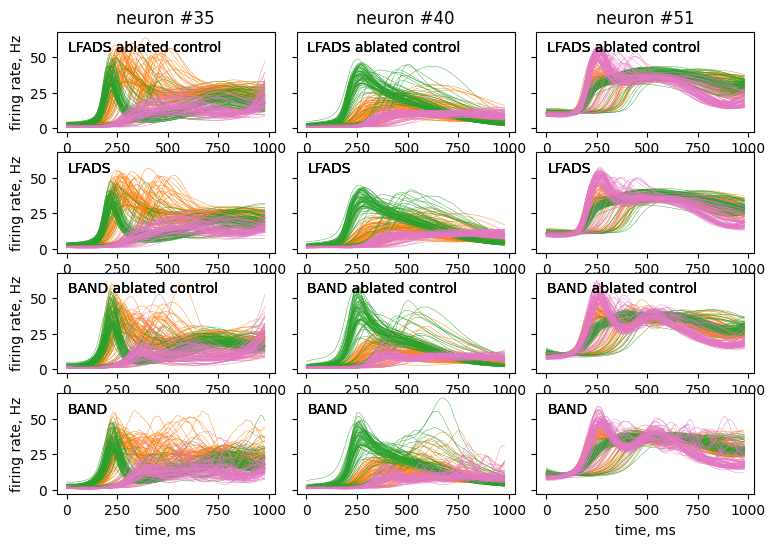

In [18]:
fig, axes = plt.subplots(4, 3, figsize=(9, 6), sharey=True)

for k, (n, sub) in enumerate(zip([35, 40, 51], [[1, 2, 6], [1,2, 6], [1,2, 6]])):
    unique_dirs = np.unique(concat_target_direction)
    time = np.arange(rates.shape[1]) * 10

    for i, (frs, title) in enumerate(zip([concat_noci_rates[0], concat_rates[0], concat_noci_rates[-1], concat_rates[-1]],
                                        ['LFADS ablated control', 'LFADS', 'BAND ablated control', 'BAND'])):
        for j, d in enumerate(unique_dirs):
            if d in unique_dirs[sub]:
                mask = concat_target_direction == d
                axes[i, k].plot(
                    time,
                    frs[mask][..., n].mean(0),
                    linewidth=1,
                    c=f"C{j}",
                    label=d,
                )
                axes[i, k].plot(
                    time, frs[mask][..., n].T, linewidth=0.3, c=f"C{j}"
                )

                if i == 0:
                    axes[0, k].set_title(f"neuron #{n}")  # , firing rate")
                if k == 0:
                    axes[i, k].set_ylabel("firing rate, Hz")
                axes[i, k].set_xlabel("time, ms")
                axes[i, k].text(0.05, 0.8, title, transform=axes[i, k].transAxes, ha='left')
                # axes[i, k].set_ylim([0, 65])

# axes[0, 0].set_title("LFADS")
# axes[0, 1].set_title("Ctrl-TNDM")

# plt.legend(loc=(1.5, 0))
plt.subplots_adjust(wspace=0.1)

# Make sure that behavior is decodable from neural firing

In [19]:
def get_target_ids(true_target_direction):
    ''' substitute direction elements with ids '''
    uniq_dirs = np.unique(true_target_direction)
    true_label = np.array([np.where(uniq_dirs==t)[0][0] for t in true_target_direction])
    return true_label

In [58]:
from plot_helpers import get_random_trials2plot

def plot_beh_pred(vel, pred_vel, dir_index, t2p, axes, area, epoch_name, select = None, component=0,title="",title_c='k'):
    '''
    Plot hand velocity and predicted hand velocity for each direction
    '''
    BIN_SIZE = 10 # ms
    time = np.arange(vel.shape[1]) * BIN_SIZE

    for v, ls in zip([vel, pred_vel], ["--", "solid"]):
        for t in range(0, vel.shape[0]):
            if t2p[t]:
                d = dir_index[t]
                if select is None:
                    d_id = d
                else:
                    if d in select:
                        d_id = np.where(select == d)[0][0]
                    else: 
                        d_id = None
                if d_id is not None:
                    axes[d_id].plot(
                        time,
                        v[t, :, component],
                        color=f"C{d}",
                        alpha=1,
                        ls=ls,
                    )

    for ax in axes[:-1]:
        ax.axis("off")
    axes[-1].spines['top'].set_visible(False)
    axes[-1].spines['right'].set_visible(False)
    axes[-1].set_yticks([])
    axes[-1].set_xlabel("Time (ms)")
    component_names = ['Velocity X', 'Velocity Y']
    axes[-1].set_ylabel(component_names[component])
    if dataset_name == 'chewie_10_07_mov':
        ylim = axes[0].get_ylim()
        axes[0].text(250,ylim[1],' mov',rotation=90,va='top',ha='right')
        for ax in axes:
            ax.axvline(250,c='k', linestyle='--')
    else:
        axes[0].text(0,10,'Go Cue',rotation=90,va='top',ha='right')
        for d in range(len(axes)):
            axes[d].axvline(0,c='k')
    

    R2_iso_vel = r2_score(vel,pred_vel) #1 - np.sum((vel - pred_vel) ** 2) / np.sum((vel - vel.mean(0)) ** 2)
    if component == 0:
        r2 = r"$R^2$"
        axes[0].set_title(f'{title} {r2} = {R2_iso_vel*100:.0f}%',loc='left',c=title_c)

np.random.seed(42)
dir_index = get_target_ids(concat_target_direction)
t2p = get_random_trials2plot(dir_index, concat_epochs.astype('int'), 1)

(0.0, 1.0, 0.0, 1.0)

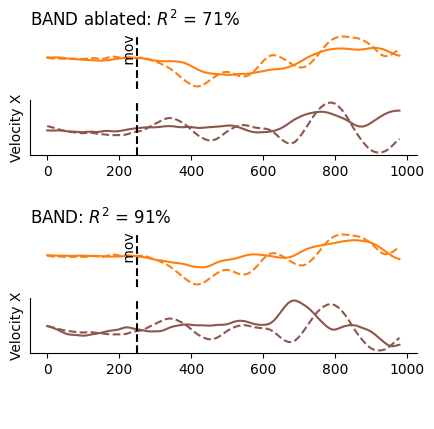

In [21]:
fig, axes = plt.subplots(6,1,figsize=(5,5))
select = [1,5]
plot_beh_pred(concat_true_behavior, concat_noci_behaviors[1], 
              dir_index, t2p, axes[:2], 
              'all', 'AD', select = select, component=0,title="BAND ablated")
axes[1].set_xlabel('')
axes[2].axis('off')
plot_beh_pred(concat_true_behavior, concat_behaviors[1],
              dir_index, t2p, axes[3:5], 
              'all', 'AD', select = select, component=0,title="BAND")
axes[4].set_xlabel('')
axes[5].axis('off')

## Classify targets

In [22]:
from plot_helpers import class_accuracy

#split train and test 80/20
#concat_noci_behaviors[1] and dir_index
class_acc_full = []
class_acc_noci = []
class_acc_lfads = []
for s in range(100):
    np.random.seed(s)
    train_inds = np.random.choice(np.arange(len(dir_index)), int(len(dir_index)*0.8), replace=False)
    test_inds = np.setdiff1d(np.arange(len(dir_index)), train_inds)

    class_full = class_accuracy(np.sum(concat_true_behavior[train_inds],1), dir_index[train_inds],
                                np.sum(concat_behaviors[1][test_inds],1), dir_index[test_inds])
    class_noci = class_accuracy(np.sum(concat_true_behavior[train_inds],1), dir_index[train_inds],
                              np.sum(concat_noci_behaviors[1][test_inds],1), dir_index[test_inds])
    
    class_lfads = class_accuracy(np.sum(concat_true_behavior[train_inds],1), dir_index[train_inds],
                                np.sum(concat_behaviors[0][test_inds],1), dir_index[test_inds])
    
    class_acc_full.append(class_full)
    class_acc_noci.append(class_noci)
    class_acc_lfads.append(class_lfads)

class_acc_full, class_acc_noci, class_acc_lfads = np.array(class_acc_full), np.array(class_acc_noci), np.array(class_acc_lfads)
print(f'Full model: {class_acc_full.mean(0)} pm {class_acc_full.std(0)}')
print(f'Noci model: {class_acc_noci.mean(0)} pm {class_acc_noci.std(0)}')
print(f'LFADS model: {class_acc_lfads.mean(0)} pm {class_acc_lfads.std(0)}')

Full model: 0.9931623931623931 pm 0.006509207782789676
Noci model: 0.8647863247863247 pm 0.023943220633479013
LFADS model: 0.9079487179487181 pm 0.0219528379656847


## make fourier transform

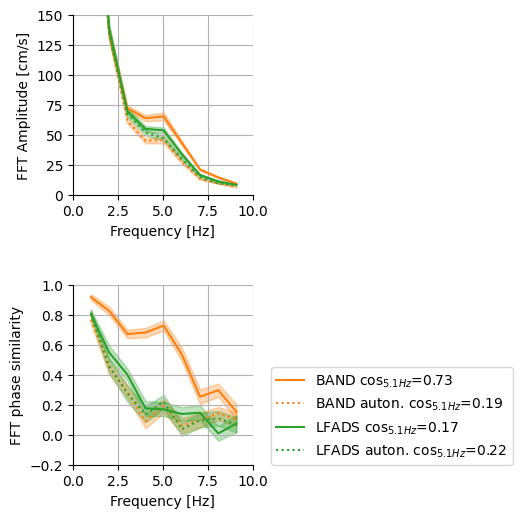

In [23]:
from plot_helpers import plot_fourier_with_cos_sim

fig = plt.figure(figsize=(6, 6))
# add blank axis
# blank = fig.add_axes([0,0,1,1], frameon=True)
axes = [fig.add_axes([0.2,0.6 - i*0.45,0.3,.3]) for i in range(2)]

component = 0

for data, label, color,ls in zip([concat_behaviors[1],
                               concat_noci_behaviors[1],
                               concat_behaviors[0],
                               concat_noci_behaviors[0]],
                               [ 'BAND','BAND auton.', 'LFADS', 'LFADS auton.'],
                               ['C1', 'C1', 'C2', 'C2'],
                               ['solid',':','solid',':']):
    plot_fourier_with_cos_sim(axes[0],axes[1],
                            data[concat_epochs==1][...,component], 
                            concat_true_behavior[concat_epochs==1][...,component],
                                label=label, peak_freq=5, c=color, linestyle=ls)

plt.legend(loc=(1.1,0),ncol=1)
plt.subplots_adjust(hspace=0.5)

fig.savefig('figs/sfig4_phase_control.pdf')

## PCA latent spaces

(581, 99, 100)
(581, 99, 100)


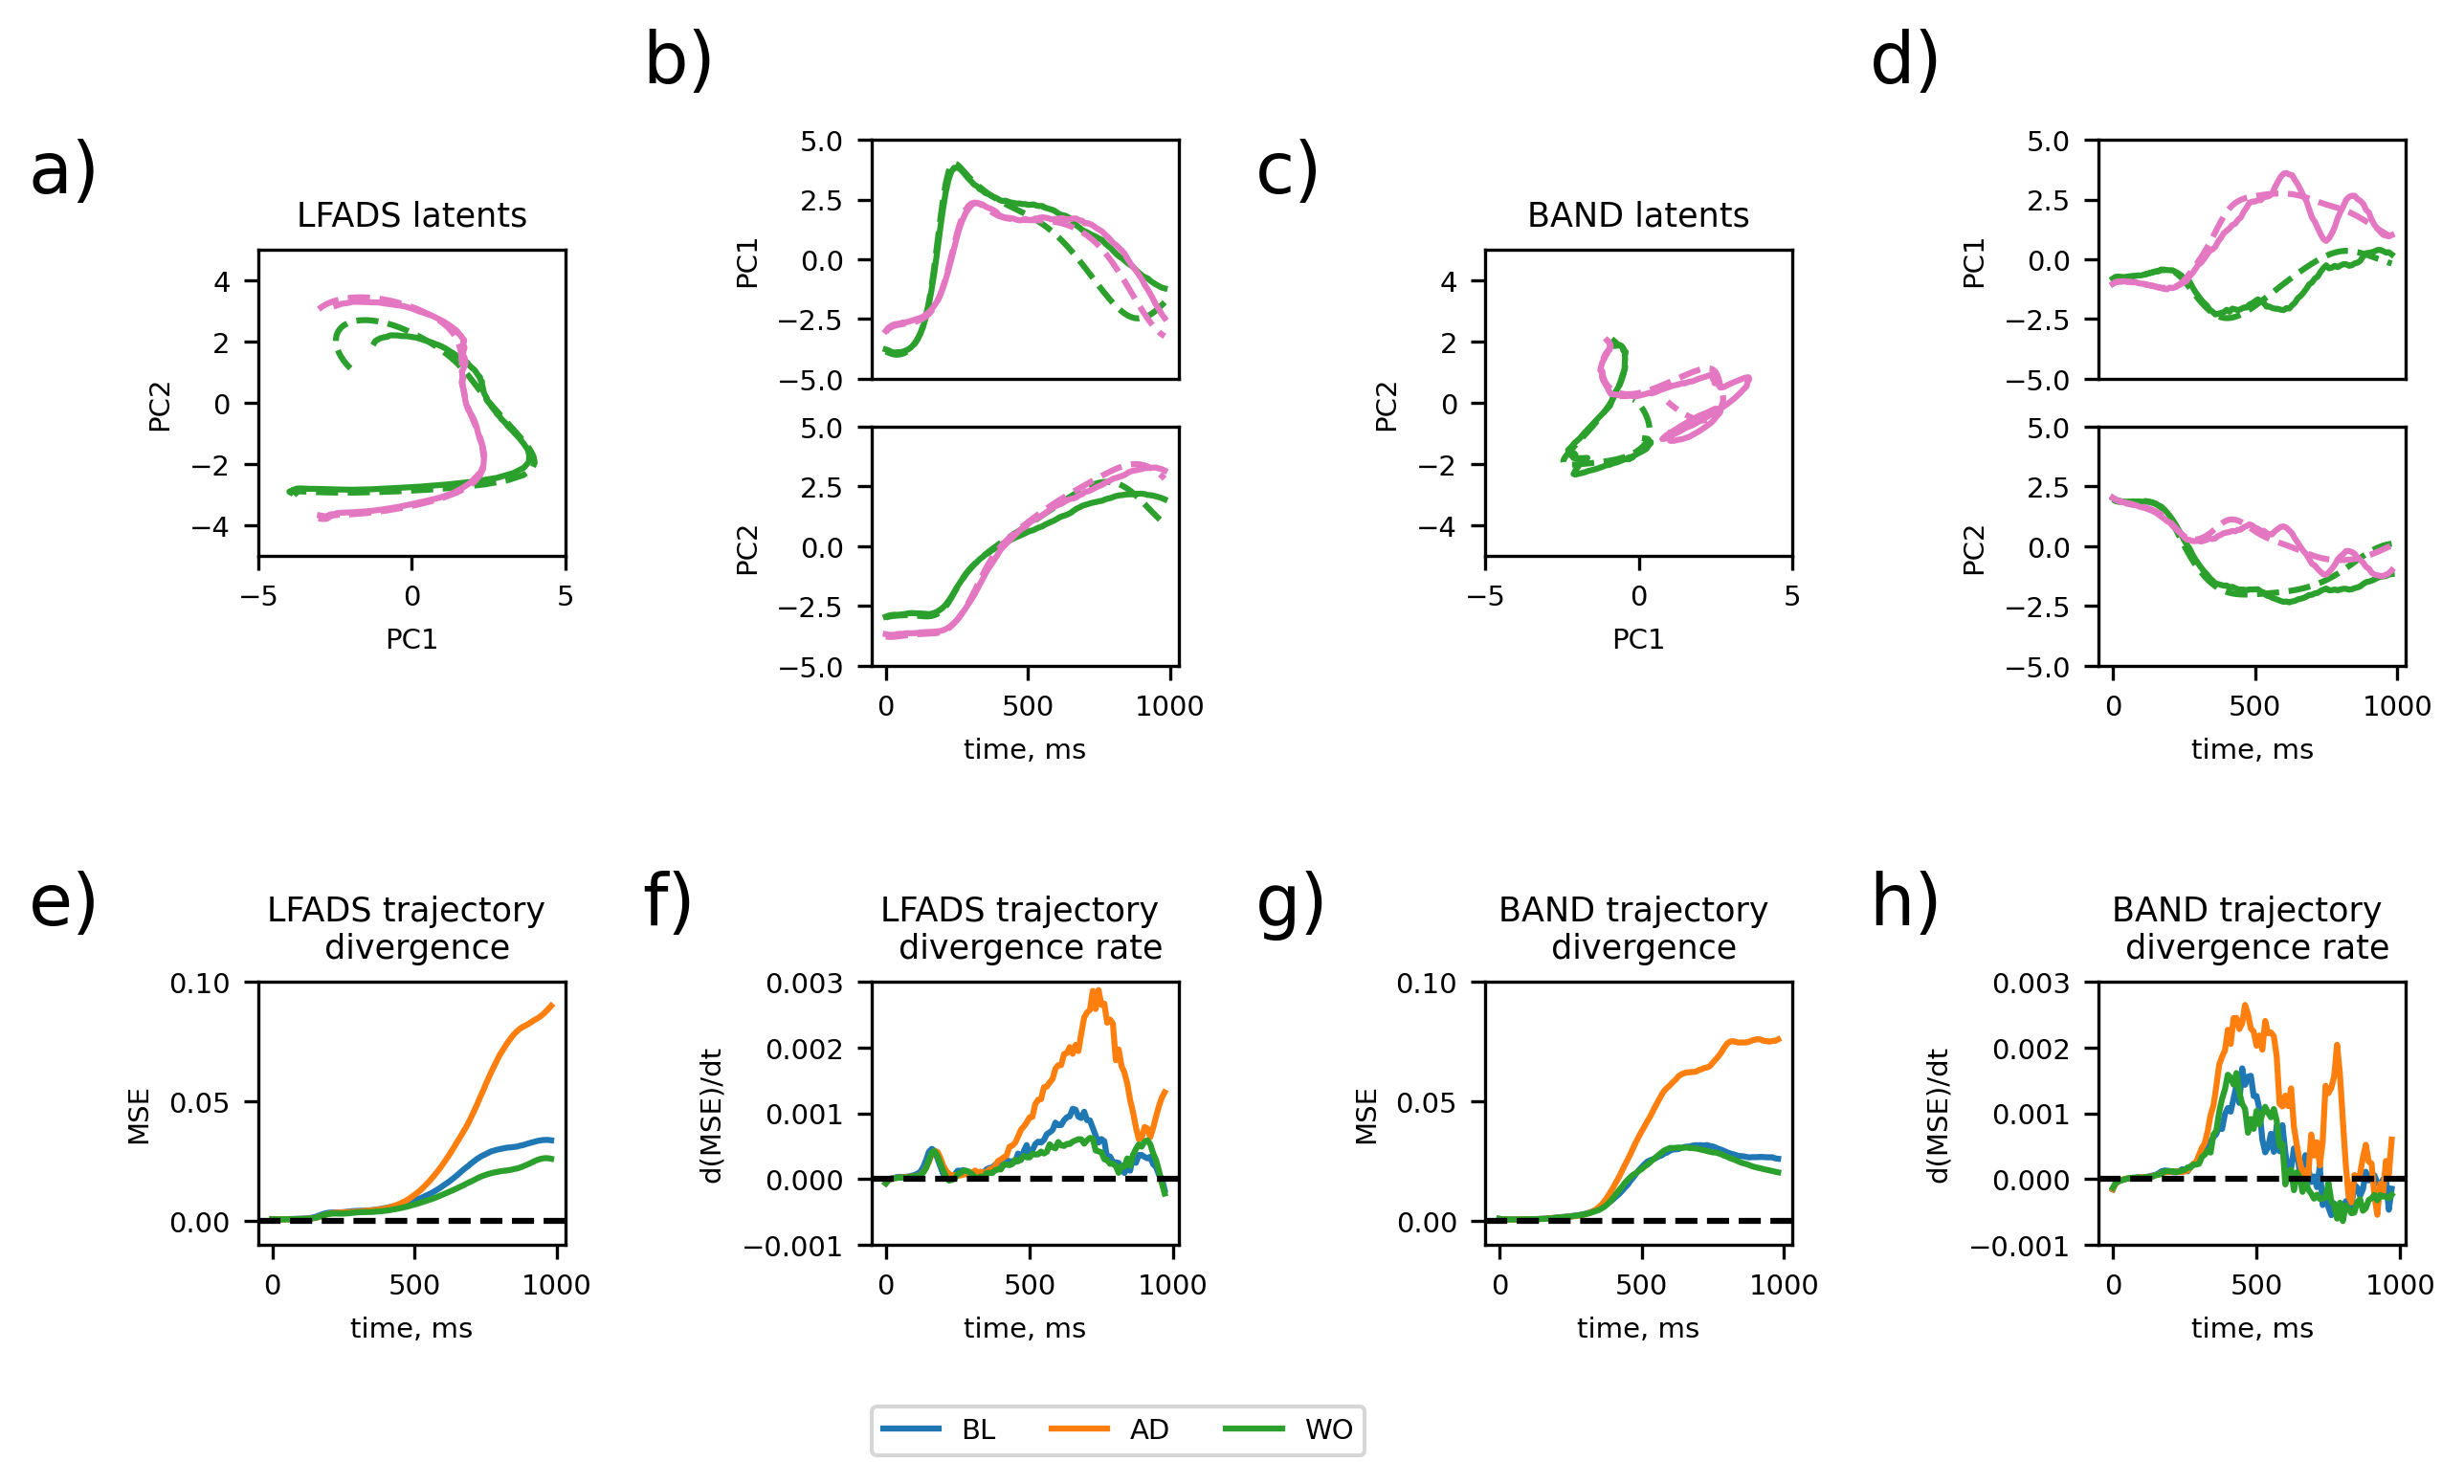

In [67]:
layout = '''
abcd
efgh
'''

fig = plt.figure(figsize=(8.5, 5))
# blank = fig.add_subplot([0,0,1,1])
specs, gs = panel_specs(layout, fig=fig, 
                        gridspec_args={'left': 0.1, 
                                       'right': .98, 
                                       'bottom': 0.15, 
                                       'top': 0.92, 
                                       'hspace': .8, 
                                       'wspace': 1})
axes = {}

w_ratios = [1,1,1,1]
h_ratios = [2,1]
gs.set_width_ratios(w_ratios)
gs.set_height_ratios(h_ratios)

for letter in 'acefgh':
    axes[letter] = ax = fig.add_subplot(specs[letter])
    label_panel(ax, letter, postfix=')')

subgs = specs['b'].subgridspec(2, 1, wspace=2.)
for j in range(2):
    axes[f"b{j}"] = ax = fig.add_subplot(subgs[j])
label_panel(axes['b0'], 'b', postfix=')')

subgs = specs['d'].subgridspec(2, 1, wspace=2.)
for j in range(2):
    axes[f"d{j}"] = ax = fig.add_subplot(subgs[j])
label_panel(axes['d0'], 'd', postfix=')')

from sklearn.decomposition import PCA

for model_label, latents_full, latents_noci, axes_letters in \
                                            zip(['LFADS','BAND'],
                                                [concat_factors[0], concat_factors[1]],
                                                [concat_factors_noci[0], concat_factors_noci[1]],
                                                ['abef','cdgh']):


    pca = PCA(n_components=2)
    pca.fit(latents_full.reshape(-1,latents_full.shape[-1]))
    print(latents_full.shape)
    latents_full_pca = pca.transform(latents_full.reshape(-1,latents_full.shape[-1])).reshape(*latents_full.shape[:2],-1)
    latents_noci_pca = pca.transform(latents_noci.reshape(-1,latents_noci.shape[-1])).reshape(*latents_full.shape[:2],-1)

    ax_a = axes[axes_letters[0]]
    ax_b0 = axes[axes_letters[1]+'0']
    ax_b1 = axes[axes_letters[1]+'1']
    ax_e = axes[axes_letters[2]]
    ax_f = axes[axes_letters[3]]

    mask = (concat_epochs==1) & (t2p==1)
    for t,at,d in zip(latents_full_pca[mask], 
                    latents_noci_pca[mask],
                    dir_index[mask]):
        if d in select:
            c = f"C{d}"
            ax_a.plot(t[:,0],t[:,1],c=c)
            ax_a.plot(at[:,0],at[:,1],c=c,linestyle='--')

            ax_b0.plot(10*np.arange(t.shape[0]),t[:,0],c=c)
            ax_b0.plot(10*np.arange(t.shape[0]),at[:,0],c=c,linestyle='--')

            ax_b1.plot(10*np.arange(t.shape[0]),t[:,1],c=c)
            ax_b1.plot(10*np.arange(t.shape[0]),at[:,1],c=c,linestyle='--')


    for e, epoch_name in enumerate(['BL','AD','WO']):
        MSE = np.mean((latents_full - latents_noci)**2,-1)[concat_epochs==e]
        ax_e.plot(np.arange(MSE.shape[1])*10,MSE.mean(0))
        mse_diff = MSE[:,1:] - MSE[:,:-1]
        ax_f.plot(np.arange(MSE.shape[1]-1)*10,mse_diff.mean(0),label=epoch_name)
    ax_e.axhline(0,c='k',linestyle='--')
    ax_f.axhline(0,c='k',linestyle='--')
    ax_e.set_title(f'{model_label} trajectory \n divergence')
    ax_f.set_title(f'{model_label} trajectory \n divergence rate')

    for letter in ['e','g']:
        axes[letter].set_ylim([-0.01,0.1])
        axes[letter].set_xlabel('time, ms')
        axes[letter].set_ylabel('MSE')

    for letter in ['f','h']:
        axes[letter].set_ylim([-0.001,0.003])
        axes[letter].set_xlabel('time, ms')
        axes[letter].set_ylabel('d(MSE)/dt')

    for letter in ['a','c']:
        axes[letter].set_xlim([-5,5])
        axes[letter].set_ylim([-5,5])
        axes[letter].set_aspect('equal')
        axes[letter].set_xlabel('PC1')
        axes[letter].set_ylabel('PC2')

    for letter in ['b','d']:
        for i in [0,1]:
            axes[letter+str(i)].set_ylabel('PC'+str(i+1))
            # axes[letter+str(i)].set_aspect(100)
            axes[letter+str(i)].set_ylim([-5,5])
        axes[letter+str(1)].set_xlabel('time, ms')
        axes[letter+str(0)].set_xticks([])


axes['a'].set_title('LFADS latents')
axes['c'].set_title('BAND latents')
axes['f'].legend(loc=(0,-.8),ncol=3)

fig.savefig('figs/sfig4_trajectory_divergence.pdf')



# Make a print-ready figure

## calculate R2

In [25]:
beh_r2 = {key: 100*r2_score(concat_behaviors[i], concat_true_behavior) for i, key in enumerate(['LFADS','BAND'])}
beh_r2.update({key: 100*r2_score(concat_noci_behaviors[i], concat_true_behavior) for i, key in enumerate(['LFADS_noci','BAND_noci'])})
print(beh_r2)

{'LFADS': 79.81982144745012, 'BAND': 92.42350175926038, 'LFADS_noci': 76.3004735481265, 'BAND_noci': 76.00736273247358}


In [26]:
dir_index = get_target_ids(concat_target_direction)
beh_r2_uive = {key: 100*r2_UIVE(concat_behaviors[i], concat_true_behavior, dir_index) for i, key in enumerate(['LFADS','BAND'])}
beh_r2_uive.update({key: 100*r2_UIVE(concat_noci_behaviors[i], concat_true_behavior,dir_index) for i, key in enumerate(['LFADS_noci','BAND_noci'])})
print(beh_r2_uive)

{'LFADS': 13.881339735971803, 'BAND': 67.44213618553924, 'LFADS_noci': -0.9828467299001207, 'BAND_noci': -1.200097207285443}


In [27]:
beh_mse = {key: np.mean((concat_behaviors[i] - concat_true_behavior)**2) for i, key in enumerate(['LFADS','BAND'])}
beh_mse.update({key: np.mean((concat_noci_behaviors[i] - concat_true_behavior)**2) for i, key in enumerate(['LFADS_noci','BAND_noci'])})

targets = concat_true_behavior
num_conditions = len(np.unique(dir_index))
avg_vel = np.zeros_like(targets)
for d in range(num_conditions):
    avg_vel[dir_index==d] = np.mean(targets[dir_index==d], axis=0)
beh_mse.update({'avg_behavior': np.mean((avg_vel - concat_true_behavior)**2)})
beh_mse.update({'var': np.mean((concat_true_behavior)**2)})

print(beh_mse)

{'LFADS': 13.802734650655685, 'BAND': 5.163920723850438, 'LFADS_noci': 16.1540086201485, 'BAND_noci': 16.34269384407906, 'avg_behavior': 15.993487159906957, 'var': 68.38819545867645}


In [28]:
def make_task_schematics(ax, x,y,r,aspect=1.,shown=np.ones(8)):

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    # bbox = ax.get_window_extent().transformed(ax.get_figure().dpi_scale_trans.inverted())
    # aspect = bbox.width / bbox.height
    # print(aspect)

    # draw a circle around the center with 8 target directions
    theta = np.roll(np.linspace(0,2*np.pi,9)[:-1],3)
    x_t = x + r*np.cos(theta)
    y_t = y + r*np.sin(theta)*aspect

    for c, (s, xt, yt) in enumerate(zip(shown, x_t,y_t)):
        fill = {'facecolors': f'C{c}'} if s else {'facecolors': 'none'}
        ax.scatter(xlim[0] + (xlim[1] - xlim[0])*xt,
                    ylim[0] + (ylim[1] - ylim[0])*yt,
                    s=20,edgecolors=f'C{c}',linewidth=.5,
                    **fill)
    ax.scatter(xlim[0] + (xlim[1] - xlim[0]) * x,
                ylim[0] + (ylim[1] - ylim[0]) * y,
                s = 20, c='k', marker='+',linewidth=.5)

In [52]:
from matplotlib import rcParams
cm = 1/2.54  # centimeters in inches

rcParams["figure.dpi"] = 300
rcParams["savefig.dpi"] = 300
rcParams["font.size"] = 7

In [72]:
help(label_panel)

Help on function label_panel in module goodman_panels:

label_panel(ax, letter, *, offset_left=0.8, offset_up=0.2, prefix='', postfix='.', **font_kwds)



(581, 99, 100)
(581, 99, 100)


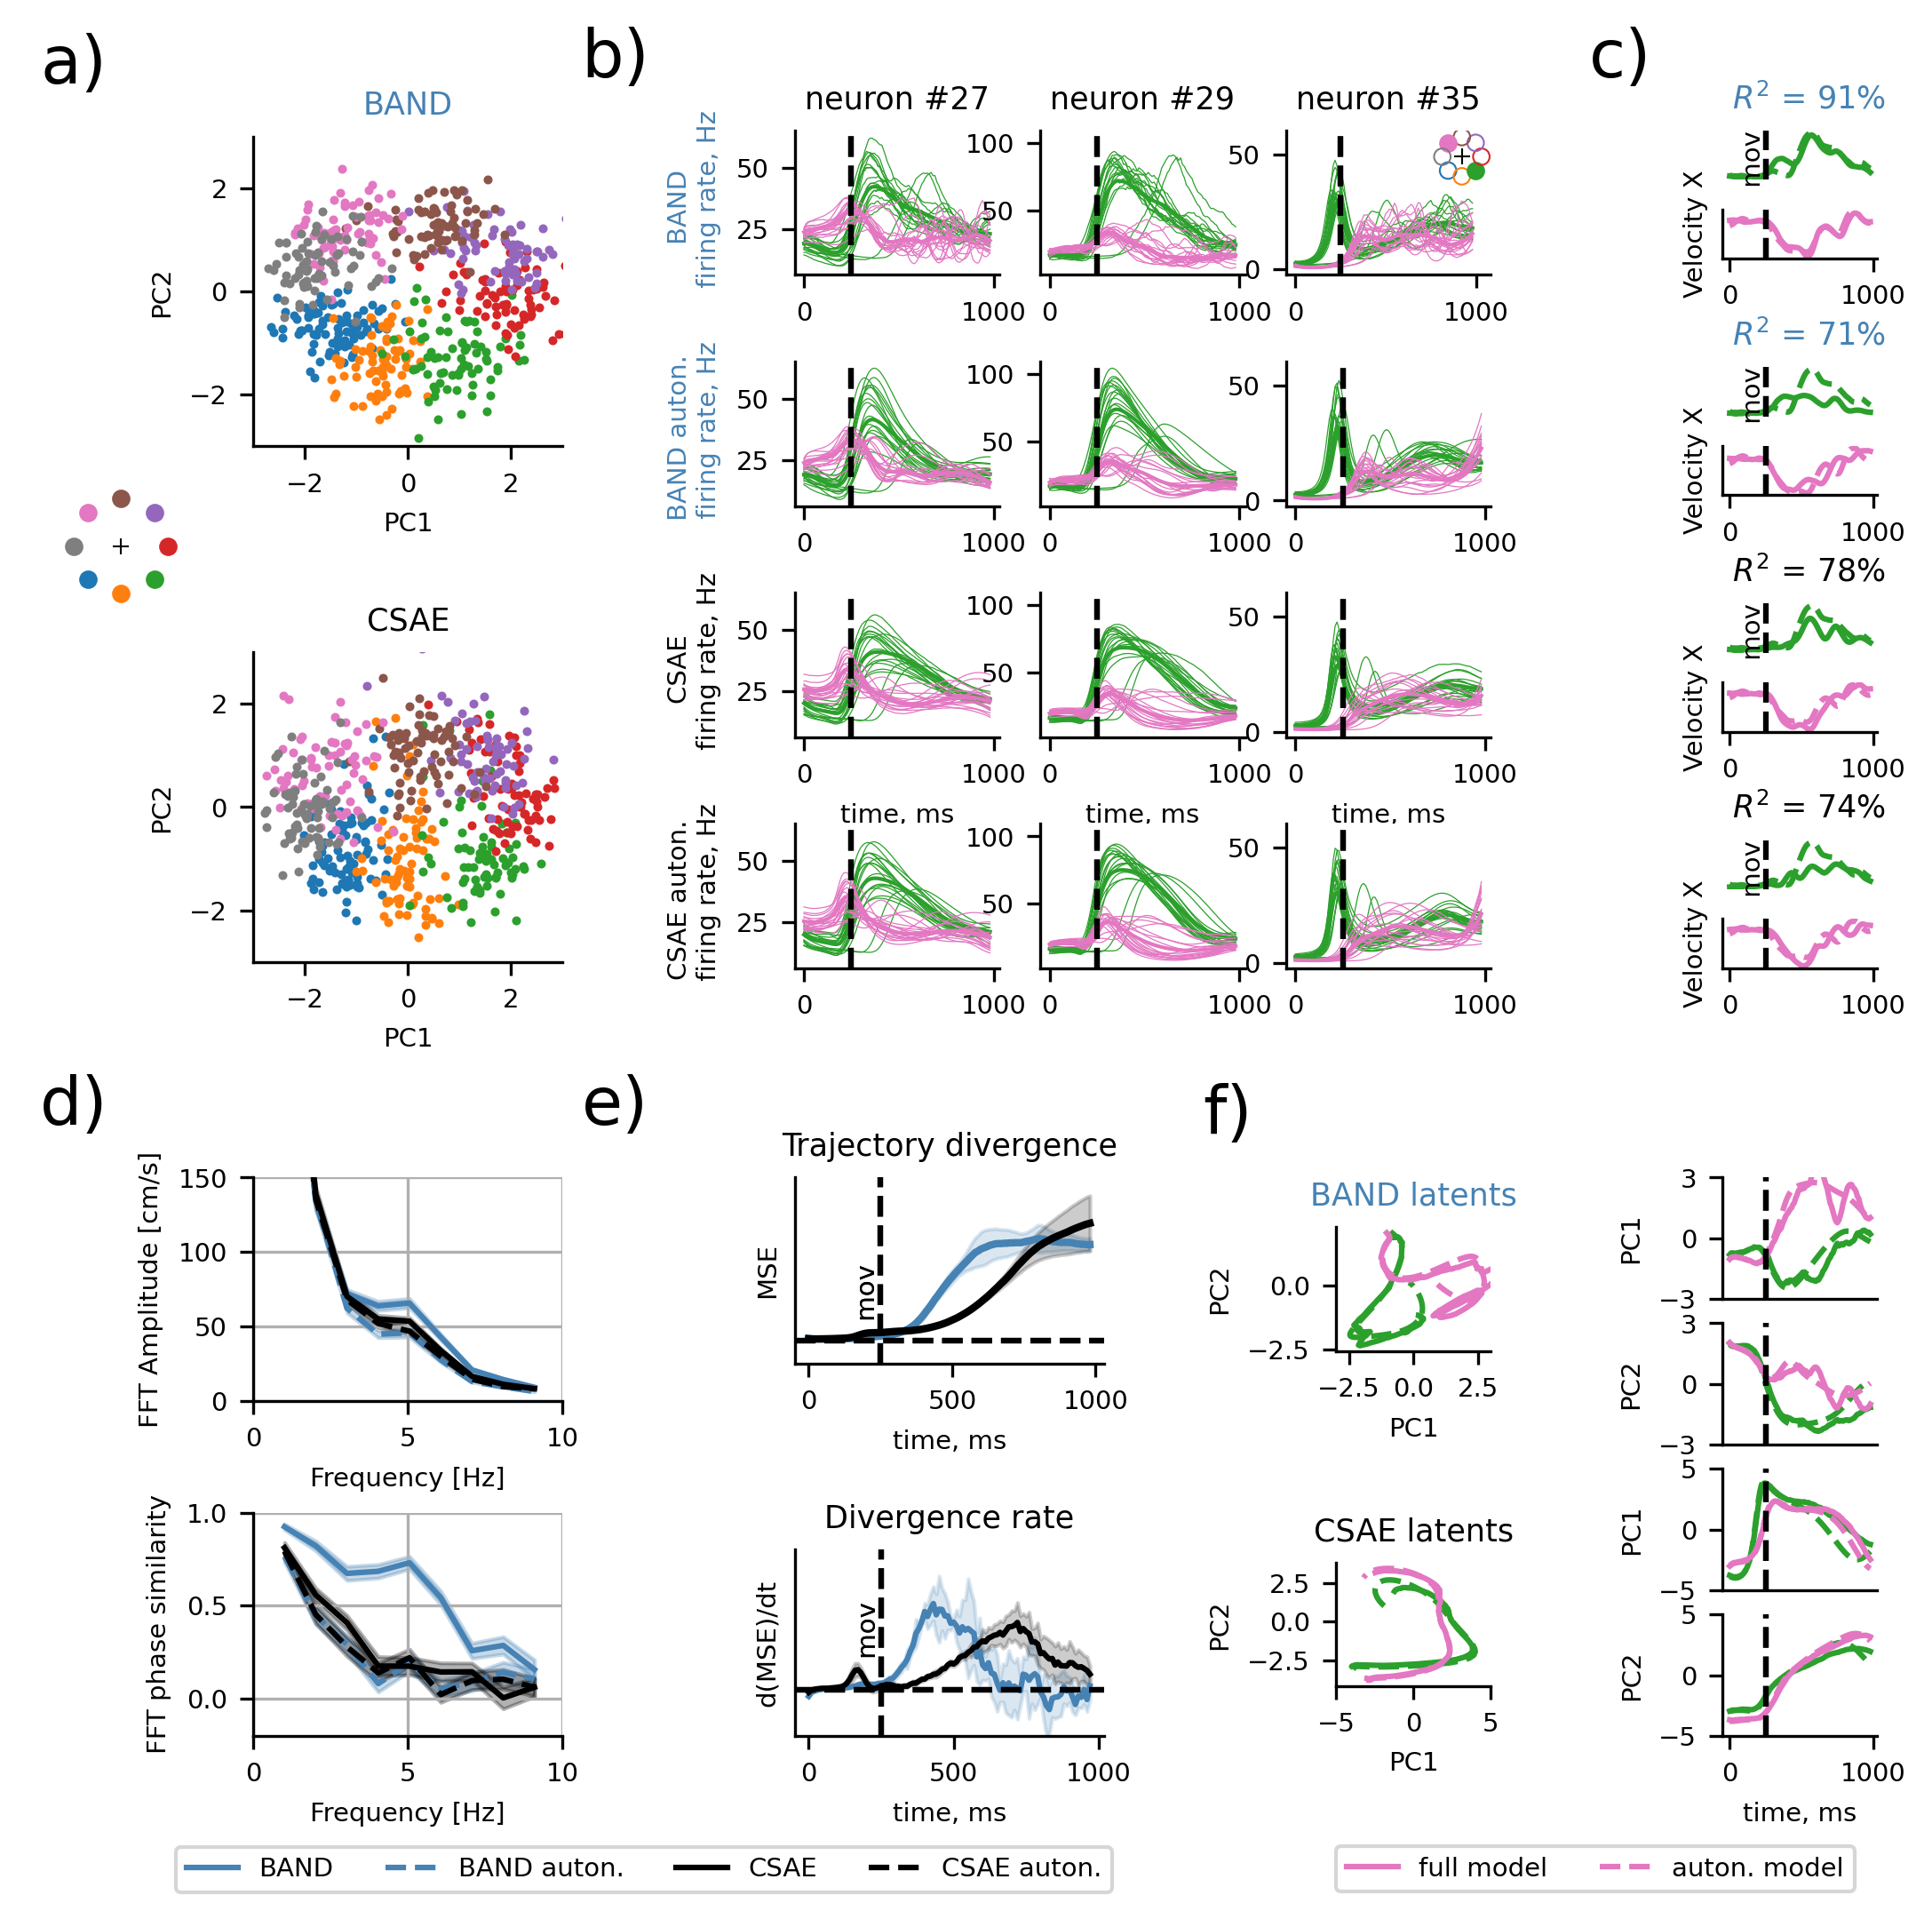

In [87]:
layout = '''
ABBC
DEFG
'''

trial_kernel_w = 5 # kernel width for smoothing over trials
select = [2,6] # directions to plot
band_color='steelblue'

fig = plt.figure(figsize=(18*cm, 18*cm))
# blank = fig.add_subplot([0,0,1,1])
specs, gs = panel_specs(layout, fig=fig, gridspec_args={'left': 0.12, 'right': .98, 'bottom': 0.09, 'top': 0.94, 'hspace': .3, 'wspace': 1})
axes = {}

w_ratios = [2,2,1,1]
h_ratios = [1.5, 1]
gs.set_width_ratios(w_ratios)
gs.set_height_ratios(h_ratios)

subgs = specs['A'].subgridspec(2, 1)
for j in range(2):
    axes[f"A{j}"] = ax = fig.add_subplot(subgs[j])
label_panel(axes['A0'], 'a', postfix=')')

model_rows = 4
subgs = specs['B'].subgridspec(model_rows, 3, wspace=0.2)
for j in range(model_rows):
    for i in range(3):
        if j == 0:
            axes[f"B{j}{i}"] = ax = fig.add_subplot(subgs[j,i])
        else:
            axes[f'B{j}{i}'] = ax = fig.add_subplot(subgs[j,i], sharey=axes[f'B0{i}'])
label_panel(axes['B00'], 'b', postfix=')')

subgs = specs['C'].subgridspec(model_rows*len(select)+(model_rows-1), 1, wspace=0.1)
for j in range(model_rows*len(select)+(model_rows-1)):
    axes[f"C{j}"] = ax = fig.add_subplot(subgs[j])
label_panel(axes['C0'], 'c', postfix=')', offset_left=0.5)

subgs = specs['D'].subgridspec(2, 1, hspace=.5)
for j in range(2):
    axes[f"D{j}"] = ax = fig.add_subplot(subgs[j])
label_panel(axes['D0'], 'd', postfix=')')

subgs = specs['E'].subgridspec(2, 1, hspace=1)
for j in range(2):
    axes[f"E{j}"] = ax = fig.add_subplot(subgs[j])
label_panel(axes['E0'], 'e', postfix=')')

subgs = specs['F'].subgridspec(2, 1, hspace=.5)
for j in range(2):
    axes[f"F{j}"] = ax = fig.add_subplot(subgs[j])
label_panel(axes['F0'], 'f', postfix=')', offset_up=.35, offset_left=.5)

subgs = specs['G'].subgridspec(4, 1, wspace=0.1,hspace=0.2)
for j in range(4):
    axes[f"G{j}"] = ax = fig.add_subplot(subgs[j])
label_panel(axes['G0'], '', postfix='')


# subgs = specs['H'].subgridspec(2, 1, wspace=0.1)
# for j in range(2):
#     axes[f"H{j}"] = ax = fig.add_subplot(subgs[j])
# label_panel(axes['H0'], 'h', postfix=')')

# Pabel A: initial conditions
for i,(j,name) in enumerate(zip([1,0],['BAND','CSAE'])):
    axes[f'A{i}'].set_title(name, c=band_color if name=='BAND' else 'k')
    
    axes[f'A{i}'].set_xlabel("PC1")
    axes[f'A{i}'].set_ylabel("PC2")
    axes[f'A{i}'].set_xlim([-3, 3])
    axes[f'A{i}'].set_ylim([-3, 3])
    axes[f'A{i}'].set_aspect('equal')

    ic_pca = concat_ic[j]

    unique_dirs = np.unique(concat_target_direction)
    for j, d in enumerate(unique_dirs):
        mask = (concat_target_direction == d) 
        axes[f'A{i}'].scatter(ic_pca[mask, 0], ic_pca[mask, 1], c=f"C{j}", s=2)

for k, (n, sub) in enumerate(zip([27, 29, 35], [select,select,select])):
    unique_dirs = np.unique(concat_target_direction)
    time = np.arange(rates.shape[1]) * 10

    for i, (frs, title) in enumerate(zip([concat_rates[1], 
                                          concat_noci_rates[1],
                                          concat_rates[0],
                                          concat_noci_rates[0]],
                                        ['BAND', 'BAND auton.', "CSAE", "CSAE auton."])):
        for j, d in enumerate(unique_dirs):
            if d in unique_dirs[sub]:
                mask = concat_target_direction == d
                axes[f'B{i}{k}'].plot(
                    time,
                    frs[mask][..., n].mean(0),
                    linewidth=1,
                    c=f"C{j}",
                    label=d,
                )
                axes[f'B{i}{k}'].plot(
                    time, frs[mask][::4,..., n].T, linewidth=0.3, c=f"C{j}"
                )
                
                if i == 0:
                    axes[f'B0{k}'].set_title(f"neuron #{n}")  # , firing rate")
                if k == 0:
                    axes[f'B{i}{k}'].set_ylabel(f"{title} \n firing rate, Hz", c=band_color if title.startswith('BAND') else 'k')
                if i == 2:
                    axes[f'B2{k}'].set_xlabel("time, ms")
                # axes[f'A{i}{k}'].text(0.05, 0.9, title, transform=axes[f'A{i}{k}'].transAxes, ha='left')

                # add movement onset mark and text
                axes[f'B{i}{k}'].axvline(250, c='k', linestyle='--')
                # axes[f'A{i}{k}'].text(250, 0.8*axes[f'A{i}{k}'].get_ylim()[1], 'mov', rotation=90, va='top', ha='right')

one_hot_select = [1 if s in select else 0 for s in range(8)]       
# add subplot between A0 and A1, on the left side
ax_a = fig.add_subplot([0, 0.67, 0.1, 0.1], frameon=False)
make_task_schematics(ax_a, 0,0,.5,aspect=1,shown=np.ones(8))
ax_a.set_xticks([])
ax_a.set_yticks([])
ax_a.set_xlim([-1, 1])
ax_a.set_ylim([-1, 1])
make_task_schematics(axes['B02'], 0.9,0.9,0.1,aspect=1.5,shown=one_hot_select)

# panel C
plot_beh_pred(concat_true_behavior, concat_behaviors[1], 
              dir_index, t2p, [axes[f'C{i}'] for i in range(len(select))], 
              'all', 'AD', select = select, component=0,title='',title_c=band_color)
axes[f'C{len(select)-1}'].set_xlabel('')
axes[f'C{len(select)}'].axis('off')
plot_beh_pred(concat_true_behavior, concat_noci_behaviors[1], 
              dir_index, t2p, [axes[f'C{i}'] for i in range(len(select)+1,len(select)*2+1)], 
              'all', 'AD', select = select, component=0,title="",title_c=band_color)
axes[f'C{len(select)*2}'].set_xlabel('')
axes[f'C{len(select)*2+1}'].axis('off')
plot_beh_pred(concat_true_behavior, concat_behaviors[0],
                dir_index, t2p, [axes[f'C{i}'] for i in range(len(select)*2+2,len(select)*3+2)], 
                'all', 'AD', select = select, component=0,title="")
axes[f'C{len(select)*3+1}'].set_xlabel('')
axes[f'C{len(select)*3+2}'].axis('off')
plot_beh_pred(concat_true_behavior, concat_noci_behaviors[0],
                dir_index, t2p, [axes[f'C{i}'] for i in range(len(select)*3+3,len(select)*4+3)], 
                'all', 'AD', select = select, component=0,title="")
axes[f'C{len(select)*4+2}'].set_xlabel('')

for i in list(range(len(select))) + list(range(len(select)+1,len(select)*2+1)):
    axes[f'C{i}'].axvline(250,c='k',linestyle='--')


# panel D
for data, label, color,ls in zip([concat_behaviors[1],
                               concat_noci_behaviors[1],
                               concat_behaviors[0],
                               concat_noci_behaviors[0]],
                               [ 'BAND','BAND auton.', 'CSAE', 'CSAE auton.'],
                               [band_color, band_color, 'k', 'k'],
                               ['solid','dashed','solid','dashed']):
    plot_fourier_with_cos_sim(axes['D0'],axes['D1'],
                            data[concat_epochs==1][...,component], 
                            concat_true_behavior[concat_epochs==1][...,component],
                                label=label, peak_freq=5, c=color, linestyle=ls)
    
axes['D0'].legend(loc=(-.25,-2.2),ncol=4)


for i, (model_label, latents_full, latents_noci) in \
                                            enumerate(zip(['BAND','CSAE'],
                                                [concat_factors[1], concat_factors[0]],
                                                [concat_factors_noci[1], concat_factors_noci[0]])):
    
    pca = PCA(n_components=2)
    pca.fit(latents_full.reshape(-1,latents_full.shape[-1]))
    print(latents_full.shape)
    latents_full_pca = pca.transform(latents_full.reshape(-1,latents_full.shape[-1])).reshape(*latents_full.shape[:2],-1)
    latents_noci_pca = pca.transform(latents_noci.reshape(-1,latents_noci.shape[-1])).reshape(*latents_full.shape[:2],-1)

    ax_a = axes[f'F{i}']
    ax_b0 = axes[f'G{2*i}']
    ax_b1 = axes[f'G{2*i+1}']
    ax_e = axes[f'E0']
    ax_f = axes[f'E1']

    mask = (concat_epochs==1) & (t2p==1)
    for t,at,d in zip(latents_full_pca[mask], 
                    latents_noci_pca[mask],
                    dir_index[mask]):
        if d in select:
            c = f"C{d}"
            ax_a.plot(t[:,0],t[:,1],c=c,label='full model' if d==select[1] else None)
            ax_a.plot(at[:,0],at[:,1],c=c,linestyle='--', label='auton. model' if d==select[1] else None)

            ax_b0.plot(10*np.arange(t.shape[0]),t[:,0],c=c)
            ax_b0.plot(10*np.arange(t.shape[0]),at[:,0],c=c,linestyle='--')

            ax_b1.plot(10*np.arange(t.shape[0]),t[:,1],c=c)
            ax_b1.plot(10*np.arange(t.shape[0]),at[:,1],c=c,linestyle='--')


    c = band_color if model_label == 'BAND' else 'k'
    MSE = np.mean((latents_full - latents_noci)**2,-1)
    mse_diff = MSE[:,1:] - MSE[:,:-1]
    MSE_estimates = []
    MSE_diff_estimates = []
    for fold in range(N_FOLDS):
        # ax_e.plot(np.arange(MSE[fold::N_FOLDS].shape[1])*10,MSE[fold::N_FOLDS].mean(0),c=c,lw=.5)
        # ax_f.plot(np.arange(MSE[fold::N_FOLDS].shape[1]-1)*10,mse_diff[fold::N_FOLDS].mean(0),c=c,lw=.5)
        MSE_estimates.append(MSE[fold::N_FOLDS].mean(0))
        MSE_diff_estimates.append(mse_diff[fold::N_FOLDS].mean(0))
    MSE_estimates = np.array(MSE_estimates)
    mse_diff = np.array(MSE_diff_estimates)
    ax_e.plot(np.arange(MSE_estimates.shape[-1])*10,MSE_estimates.mean(0),c=c,lw=2)
    ax_e.fill_between(np.arange(MSE_estimates.shape[-1])*10,
                      MSE_estimates.mean(0) - MSE_estimates.std(0),
                      MSE_estimates.mean(0) + MSE_estimates.std(0),
                      color=c, alpha=0.2)
    
    ax_f.plot(np.arange(MSE.shape[1]-1)*10,mse_diff.mean(0),label=model_label,c=c)
    ax_f.fill_between(np.arange(MSE.shape[1]-1)*10,
                      mse_diff.mean(0) - mse_diff.std(0),
                      mse_diff.mean(0) + mse_diff.std(0),
                      color=c, alpha=0.2)
    ax_e.axhline(0,c='k',linestyle='--')
    ax_f.axhline(0,c='k',linestyle='--')
    ax_e.set_title(f'Trajectory divergence')
    ax_f.set_title(f'Divergence rate')

    axes['E0'].set_ylim([-0.01,0.07])
    axes['E0'].set_ylabel('MSE')

    axes['E1'].set_ylim([-0.001,0.003])
    axes['E1'].set_ylabel('d(MSE)/dt')
    

    for letter in ['E0','E1']:
        axes[letter].set_yticks([])
        axes[letter].set_xlabel('time, ms')
        axes[letter].axvline(250,c='k',linestyle='--')
    
    axes['E0'].text(250,0.005,' mov',rotation=90,va='bottom',ha='right')
    axes['E1'].text(250,0.0005,' mov',rotation=90,va='bottom',ha='right')

    for letter in ['F0','F1']:
        axes[letter].set_aspect('equal')
        axes[letter].set_xlabel('PC1')
        axes[letter].set_ylabel('PC2')

    axes['F0'].set_xlim([-3,3])
    axes['F1'].set_xlim([-5,5])

    for letter in ['G']:
        for j in [0,1,2,3]:
            axes[letter+str(j)].set_ylabel('PC'+str(j%2+1))
            # axes[letter+str(j)].set_aspect(50)
            if j>1:
                axes[letter+str(j)].set_ylim([-5,5])
            else:
                axes[letter+str(j)].set_ylim([-3,3])
                axes[letter+str(j)].set_yticks([-3,0,3])
            if j!=3:
                axes[letter+str(j)].set_xticks([])
            axes[letter+str(j)].axvline(250,c='k',linestyle='--')
        axes[letter+str(3)].set_xlabel('time, ms')


axes['F1'].set_title('CSAE latents')
axes['F0'].set_title('BAND latents',c=band_color)
axes['F0'].legend(loc=(0,-4.35),ncol=2)

for k in axes.keys():
    axes[k].spines['right'].set_visible(False)
    axes[k].spines['top'].set_visible(False)

plt.subplots_adjust(hspace=0.6)
# plt.tight_layout()
plt.savefig(f"figs/fig5a_{dataset_name}_{model_name}.pdf")   
plt.savefig(f"figs/fig5a_{dataset_name}_{model_name}.png")
# plt.savefig('test.ps')